# Sensitivity Analysis: RfR
### The goal is to intervene in the system, starting from the parameters to which the model is most sensitive.
Global sensitivity analysis: uncertain inputs are sampled at the same time (e.g. with Monte Carlo/Latin Hypercube), instead of checking each input separately, next we try to understand how uncertainty in model output is a function of uncertainty in model input.
#### The following sensitivity analysis aims to:
- Find which uncertain inputs are more influential on outputs;
- How much of the uncertainty is epistemic; how much is irreducible;
- Which uncertain inputs should be a priority for research;
- Which inputs be left out/aggregated to simplify the model.

#### Methods:
- Sobol sampling

## Import packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, 
                           ScalarOutcome,
                           TimeSeriesOutcome,
                           IntegerParameter,
                           CategoricalParameter,
                           RealParameter, 
                           perform_experiments, 
                           ema_logging,
                           Policy, 
                           MultiprocessingEvaluator, 
                           save_results, 
                           load_results)

from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from dike_model_function import DikeNetwork  # @UnresolvedImport
from dike_model_function_time_series import DikeNetworkTS  # @UnresolvedImport
from problem_formulation_actors import get_model_for_actor_problem_formulation

## Importing the model
Importing the RfR model using a custom function for convenience.

In [2]:
# Problem formulations:
#    get_model_for_actor_problem_formulation(problem_formulation_id, outcome_type='time_series')
#    problem_formulation_id options
#        1 - RWS (GOOD)
#        2 - Environmental interest group
#        3 - Transport company 
#        4 - Delta commission
#        5 - Gelderland (GOOD)
#        6 - Overijssel (GOOD)s
#        7 - Dike rings 1 and 2
#        8 - Dike ring 3
#        9 - Dike ring 4
#        10 - Dike ring 5
#
#    outcome_type options
#        'time_series' (default)
#        'scalar'

model, planning_steps = get_model_for_actor_problem_formulation(1, outcome_type='scalar')

# Sobol global sensitivity analysis over Uncertainties

In [3]:
# Define uncertainties and convert them to SALib desired format
uncertainties = []
for unc in model.uncertainties:
    uncertainties.append(unc)

problem = get_SALib_problem(uncertainties)

In [4]:
# Define the 'non-policy', setting all policy levers to zero
levers = []
for lev in model.levers:
    levers.append(lev)

non_policy = Policy("No action", **{l.name:0 for l in levers})

In [5]:
# Perform experiments using Sobol sampling over uncertainties, evaluating over non_policy
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenario = 60

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=n_scenario, policies=non_policy,
                                                                      uncertainty_sampling=SOBOL)
    
results_uncertainty = experiments_sobol, outcomes_sobol

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2400 scenarios * 1 policies * 1 model(s) = 2400 experiments
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1680 cases completed
[MainProcess/INFO] 1920 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
save_results(results_uncertainty,'Outputs/experiments_sobol_2000cases.tar.gz' )

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,29.0,60.9375,1.5,0.676758,119.6875,1.5,0.045898,317.8125,1.5,0.069336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40000,No action,dikesnet
1,95.0,60.9375,1.5,0.676758,119.6875,1.5,0.045898,317.8125,1.5,0.069336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40001,No action,dikesnet
2,29.0,197.1875,1.5,0.676758,119.6875,1.5,0.045898,317.8125,1.5,0.069336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40002,No action,dikesnet
3,29.0,60.9375,1.5,0.676758,119.6875,1.5,0.045898,317.8125,1.5,0.069336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40003,No action,dikesnet
4,29.0,60.9375,1.5,0.950195,119.6875,1.5,0.045898,317.8125,1.5,0.069336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40004,No action,dikesnet


In [8]:
# Expected Annual Damage Sobol outcomes
EAD_final_sobol = outcomes_sobol['Expected Annual Damage']
EAD_score = sobol.analyze(problem, EAD_final_sobol, calc_second_order=True, print_to_console=False)

# Total Investment Costs Sobol outcomes - USING non-policy THIS REMAINS ZERO
TIC_final_sobol = outcomes_sobol['Total Investment Costs']
TIC_score = sobol.analyze(problem, TIC_final_sobol, calc_second_order=True, print_to_console=False)

# Expected Number of Deaths Sobol outcomes
END_final_sobol = outcomes_sobol['Expected Number of Deaths']
END_score = sobol.analyze(problem, END_final_sobol, calc_second_order=True, print_to_console=False)

In [15]:
def plot_sobol_interaction(sobol_score):
    Si_filter = {k:sobol_score[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(16,12)
    fig.subplots_adjust(bottom=0.3)
    plt.title('Sobol Score')
    ax.set(xlabel='Uncertainty', ylabel='Fraction of total variance')
    plt.show()
    
# We can also study the convergence of the Sobol indices as a function of the number of samples,
# by computing the indices over a partial sample:

def plot_sobol_convergence(final_sobol):

    s_data = pd.DataFrame(index=problem['names'],
                          columns=np.arange(1,n_scenario,5)*(2*problem['num_vars']+2))
    for j in s_data.columns:
        scores = sobol.analyze(problem, final_sobol[0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:,j] = scores['ST']
        
    fig, ax = plt.subplots(1)

    s_data.T.plot(ax=ax)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Total index (ST)')
    plt.title('Sobol Convergence')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

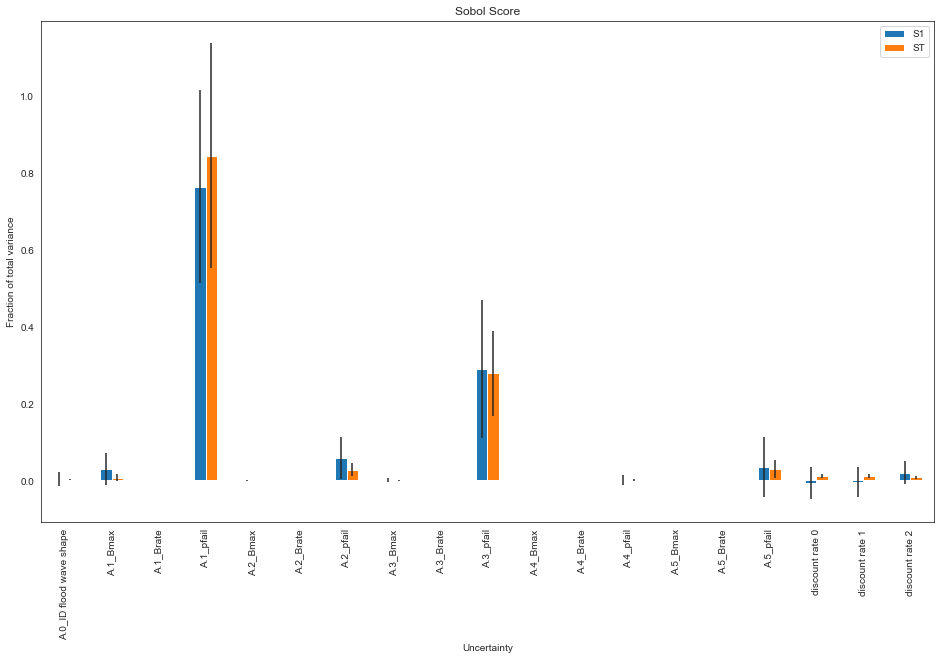

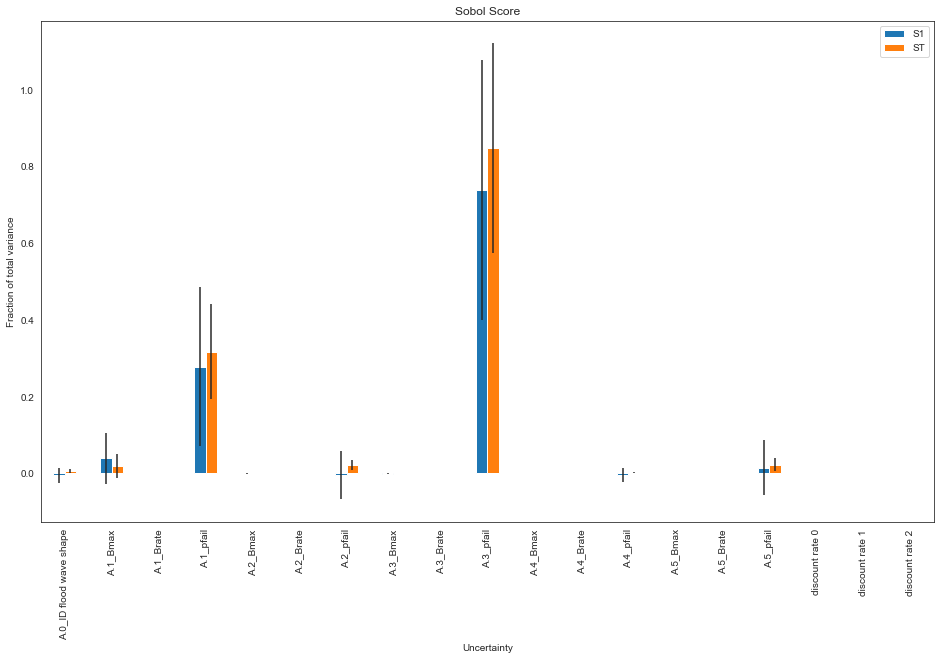

In [16]:
plot_sobol_interaction(EAD_score)
plot_sobol_interaction(END_score)

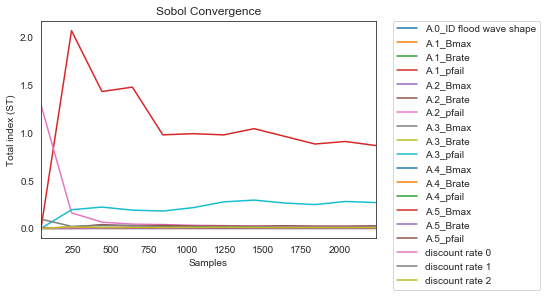

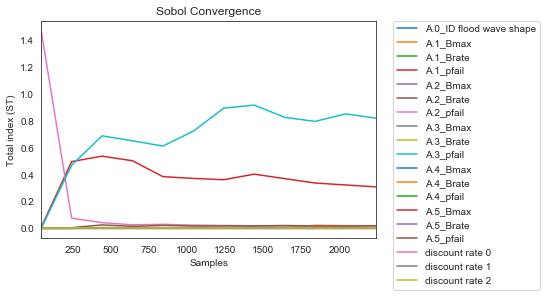

In [17]:
plot_sobol_convergence(EAD_final_sobol)
plot_sobol_convergence(END_final_sobol)

# Sobol global sensitivity analysis over LEVERS

In [18]:
# Define LEVERS and convert them to SALib desired format
levers = []
for lev in model.levers:
    levers.append(lev)

problem_levers = get_SALib_problem(levers)

In [21]:
# Define the 'non-uncertainty', setting all uncertainties to zero
uncertainties = []
for unc in model.uncertainties:
    uncertainties.append(unc)

non_uncertainty = Policy("No uncertainty", **{u.name:1 for u in uncertainties})

In [23]:
uncertainties

[CategoricalParameter('discount rate 0', [0, 1, 2, 3]),
 CategoricalParameter('discount rate 1', [0, 1, 2, 3]),
 CategoricalParameter('discount rate 2', [0, 1, 2, 3]),
 IntegerParameter('A.0_ID flood wave shape', 0, 132),
 RealParameter('A.1_Bmax', 30, 350),
 RealParameter('A.1_pfail', 0, 1),
 CategoricalParameter('A.1_Brate', [0, 1, 2]),
 RealParameter('A.2_Bmax', 30, 350),
 RealParameter('A.2_pfail', 0, 1),
 CategoricalParameter('A.2_Brate', [0, 1, 2]),
 RealParameter('A.3_Bmax', 30, 350),
 RealParameter('A.3_pfail', 0, 1),
 CategoricalParameter('A.3_Brate', [0, 1, 2]),
 RealParameter('A.4_Bmax', 30, 350),
 RealParameter('A.4_pfail', 0, 1),
 CategoricalParameter('A.4_Brate', [0, 1, 2]),
 RealParameter('A.5_Bmax', 30, 350),
 RealParameter('A.5_pfail', 0, 1),
 CategoricalParameter('A.5_Brate', [0, 1, 2])]

In [25]:
# Perform experiments using Sobol sampling over uncertainties, evaluating over non_policy
ema_logging.log_to_stderr(ema_logging.INFO)

n_policy = 60

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sobol_levers, outcomes_sobol_levers = evaluator.perform_experiments(scenarios=1, policies=n_policy,
                                                                      uncertainty_sampling=SOBOL)
    
results_levers = experiments_sobol_levers, outcomes_sobol_levers

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 40 scenarios * 60 policies * 1 model(s) = 2400 experiments
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1680 cases completed
[MainProcess/INFO] 1920 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
save_results(results_levers,'Outputs/experiments_leevrs_sobol_2400cases.tar.gz' )

In [ ]:
# Expected Annual Damage Sobol outcomes LEVERS
EAD_final_sobol_levers = outcomes_sobol['Expected Annual Damage']
EAD_score_levers = sobol.analyze(problem_levers, EAD_final_sobol_levers, calc_second_order=True, print_to_console=False)

# Total Investment Costs Sobol outcomes LEVERS
TIC_final_sobol_levers = outcomes_sobol['Total Investment Costs']
TIC_score_levers = sobol.analyze(problem_levers, TIC_final_sobol_levers, calc_second_order=True, print_to_console=False)

# Expected Number of Deaths Sobol outcomes LEVERS
END_final_sobol_levers = outcomes_sobol['Expected Number of Deaths']
END_score_levers = sobol.analyze(problem_levers, END_final_sobol_levers, calc_second_order=True, print_to_console=False)